In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import tensorflow_datasets as tfds

## Citation

```
@inproceedings{bossard14,
  title = {Food-101 -- Mining Discriminative Components with Random Forests},
  author = {Bossard, Lukas and Guillaumin, Matthieu and Van Gool, Luc},
  booktitle = {European Conference on Computer Vision},
  year = {2014}
}
```

# Data
TensorFlow has the food 101 dataset already. We will use this! https://www.tensorflow.org/datasets/catalog/food101

Samosa is label 85

In [ ]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteDVRD3W/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteDVRD3W/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
train_ds, valid_ds = ds["train"], ds["validation"]

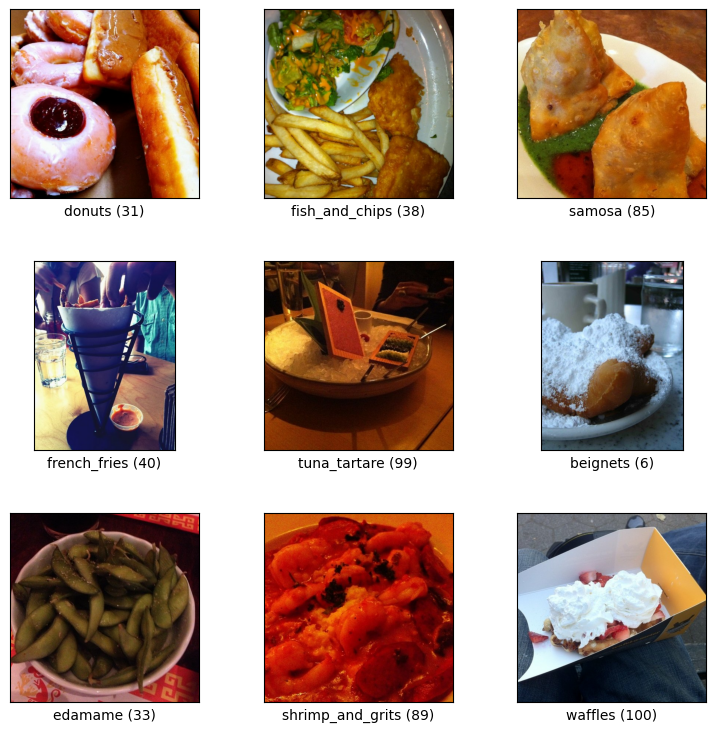

In [ ]:
fig = tfds.show_examples(train_ds, ds_info)

In [ ]:
MAX_SIDE_LEN = 128
SAMOSA_CLASS = 85
train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), tf.cast(label == SAMOSA_CLASS, dtype=tf.int32))
)
valid_ds = valid_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), tf.cast(label == SAMOSA_CLASS, dtype=tf.int32))
)

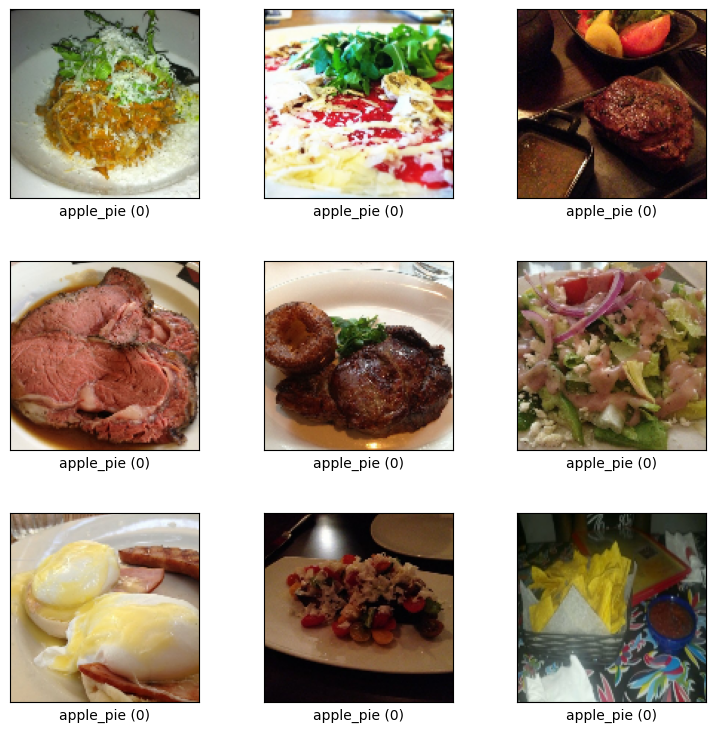

In [ ]:
fig = tfds.show_examples(train_ds, ds_info)

In [ ]:
train_hd_size, valid_hd_size = 750, 250
train_samosa = train_ds.filter(lambda _, label: label == 1).repeat(3)
train_notsamosa = train_ds.filter(lambda _, label: label == 0)

In [ ]:
valid_samosa = valid_ds.filter(lambda _, label: label == 1).repeat(3)
valid_notsamosa = valid_ds.filter(lambda _, label: label == 0)

In [ ]:
valid_samosa

<_RepeatDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [ ]:
batch_size = 16
train_ds = tf.data.Dataset.sample_from_datasets([train_samosa, train_notsamosa], weights=[0.5, 0.5], stop_on_empty_dataset=True)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.sample_from_datasets([valid_samosa, valid_notsamosa], weights=[0.5, 0.5], stop_on_empty_dataset=True)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
for image, label in train_ds.take(3):
  print(image[0][0][0])
  print(label)

tf.Tensor([83 71 47], shape=(3,), dtype=int32)
tf.Tensor([0 0 0 1 0 0 0 1 1 0 0 1 1 1 0 1], shape=(16,), dtype=int32)
tf.Tensor([1 1 1], shape=(3,), dtype=int32)
tf.Tensor([0 1 1 1 0 1 0 1 1 1 0 0 0 0 0 0], shape=(16,), dtype=int32)
tf.Tensor([117  54  12], shape=(3,), dtype=int32)
tf.Tensor([1 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0], shape=(16,), dtype=int32)


# Neural Network implementation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
random.seed(0)
model = models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(MAX_SIDE_LEN, MAX_SIDE_LEN, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))

In [ ]:
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/50
281/281 [==============================] - 472s 2s/step - loss: 1.6664 - accuracy: 0.4971 - val_loss: 1.2130 - val_accuracy: 0.4788
Epoch 2/50
281/281 [==============================] - 10s 35ms/step - loss: 0.9987 - accuracy: 0.4989 - val_loss: 0.8477 - val_accuracy: 0.4788
Epoch 3/50
281/281 [==============================] - 10s 35ms/step - loss: 0.7819 - accuracy: 0.5098 - val_loss: 0.7343 - val_accuracy: 0.5233
Epoch 4/50
281/281 [==============================] - 10s 35ms/step - loss: 0.7201 - accuracy: 0.5174 - val_loss: 0.7012 - val_accuracy: 0.5261
Epoch 5/50
281/281 [==============================] - 10s 35ms/step - loss: 0.6960 - accuracy: 0.5368 - val_loss: 0.6856 - val_accuracy: 0.5594
Epoch 6/50
281/281 [==============================] - 10s 35ms/step - loss: 0.6834 - accuracy: 0.5531 - val_loss: 0.6769 - val_accuracy: 0.5997
Epoch 7/50
281/281 [==============================] - 10s 35ms/step - loss: 0.6804 - accuracy: 0.5562 - val_loss: 0.6715 - val_accuracy: 

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in valid_ds.take(1):
  images = image_batch
  labels = label_batch

<Figure size 1000x1000 with 0 Axes>

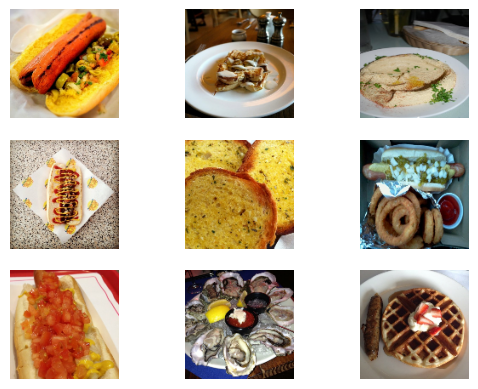

In [ ]:
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(images[i])
  plt.axis("off")

In [ ]:
labels[:9]

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([1, 0, 0, 1, 0, 1, 1, 0, 0], dtype=int32)>